In [50]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Directory containing the pickle files
results_dir = './results_fanout'

# List all .pkl files in the directory
pickle_files = [f for f in os.listdir(results_dir) if f.endswith('.pkl')]

# Read each pickle file into a DataFrame and store in a dictionary
dataframes = {}
for file in pickle_files:
    file_path = os.path.join(results_dir, file)
    df_name = os.path.splitext(file)[0]
    dataframes[df_name] = pd.read_pickle(file_path)

# Display the first few rows of each dataframe to understand their structure
for name, df in dataframes.items():
    print(f"DataFrame: {name}")
    print(df.head())
    print("\n")

DataFrame: baseline_p-24_mps-1000
                                  event_id  \
0   47421989598966360392504764391707563113   
1   62907228128626478330625561369371074200   
2  137611433393878134482317137473527131151   
3  178860926629541471776633033997559867378   
4  118431365802015972656116436306146973835   

                                                sent              sent_t  \
0  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   
1  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   
2  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   
3  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   
4  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   

                                                 ret               ret_t  \
0  EventResult(event_id=4742198959896636039250476...  (2, 1742998791530)   
1  EventResult(event_id=6290722812862647833062556...  (2, 1742998790236)   
2  E

In [51]:
for name, df in dataframes.items():
    min_event_id = df['event_id'].min()
    df['request_id'] = df['event_id'] - min_event_id

# Display the first few rows of each dataframe to verify the changes
for name, df in dataframes.items():
    print(f"DataFrame: {name}")
    print(df.head())
    print("\n")

DataFrame: baseline_p-24_mps-1000
                                  event_id  \
0   47421989598966360392504764391707563113   
1   62907228128626478330625561369371074200   
2  137611433393878134482317137473527131151   
3  178860926629541471776633033997559867378   
4  118431365802015972656116436306146973835   

                                                sent              sent_t  \
0  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   
1  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   
2  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   
3  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   
4  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   

                                                 ret               ret_t  \
0  EventResult(event_id=4742198959896636039250476...  (2, 1742998791530)   
1  EventResult(event_id=6290722812862647833062556...  (2, 1742998790236)   
2  E

In [52]:
# Combine all dataframes into a single dataframe with the filename as a key
combined_df = pd.concat(dataframes, names=['filename']).reset_index(level=0)

# Display the combined dataframe
print(combined_df.head())

                 filename                                 event_id  \
0  baseline_p-24_mps-1000   47421989598966360392504764391707563113   
1  baseline_p-24_mps-1000   62907228128626478330625561369371074200   
2  baseline_p-24_mps-1000  137611433393878134482317137473527131151   
3  baseline_p-24_mps-1000  178860926629541471776633033997559867378   
4  baseline_p-24_mps-1000  118431365802015972656116436306146973835   

                                                sent              sent_t  \
0  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   
1  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   
2  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   
3  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   
4  Event(target=StatelessOpNode(id=18, operator=<...  (2, 1742998786412)   

                                                 ret               ret_t  \
0  EventResult(event_id=4742198959896636039250

In [53]:
import re

def preprocess(name, df, warmup_time_s=1):
    # Extract parallelism and mps from the name using regex
    match = re.search(r'(.+)_p-(\d+)_mps-(\d+)', name)
    if match:
        experiment = match.group(1)
        parallelism = int(match.group(2))
        mps = int(match.group(3))
    else:
        raise Exception()
    
    # Ignore the first warmup_time seconds of events
    warmup_events = int(warmup_time_s * mps)
    df = df.iloc[warmup_events:]

    # Calculate the additional Kafka overhead
    # df['kafka_overhead'] = df['latency'] - df['flink_time']

    # Extract median values from df
    flink_time_median = df['flink_time'].median()
    flink_time_99_percentile = df['flink_time'].quantile(0.99)
    latency_median = df['latency'].median()
    latency_99_percentile = df['latency'].quantile(0.99)

    return {
        'experiment': experiment,
        'parallelism': parallelism,
        'mps': mps,
        'flink_time_median': flink_time_median,
        'latency_median': latency_median,
        'latency_99_percentile': latency_99_percentile,
        'flink_time_99_percentile': flink_time_99_percentile
    }

# Preprocess all dataframes
preprocessed_data = []
for name, df in dataframes.items():
    try:
        result = preprocess(name, df)
        preprocessed_data.append(result)
    except Exception as e:
        print(f"Failed to preprocess {name}: {e}")

# Convert the preprocessed data into a DataFrame
preprocessed_df = pd.DataFrame(preprocessed_data)

# Display the preprocessed DataFrame
print(preprocessed_df)

   experiment  parallelism   mps  flink_time_median  latency_median  \
0    baseline           24  1000        5222.234130         39075.0   
1    baseline           24  1500        6717.018962        106289.5   
2    baseline           24   200         228.648186           600.5   
3    baseline           24  2000        8483.538866        175810.5   
4    baseline           24   400         553.120494           893.0   
5    baseline           24   600        2086.555958          8438.0   
6    baseline           24   800        5131.814718         23682.0   
7    parallel           24  1000          54.172277           607.0   
8    parallel           24  1500          74.910402          1328.0   
9    parallel           24   200          30.788779            39.0   
10   parallel           24  2000          70.707440          2653.0   
11   parallel           24   400          20.503402            32.0   
12   parallel           24   600          22.993922            37.0   
13   p

KeyError: "None of [Index(['baseline', 'pipelined', 'parallel'], dtype='object', name='experiment')] are in the [columns]"

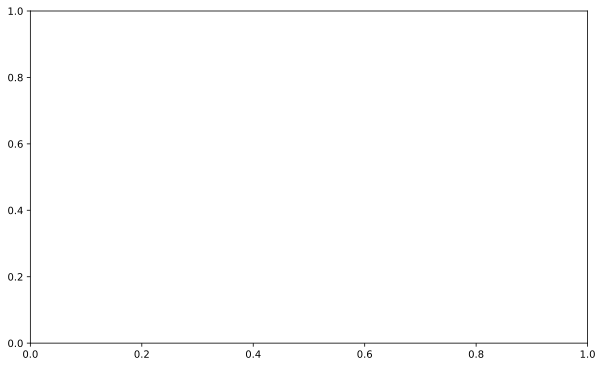

In [54]:
def plot_relative_speedup(preprocessed_df, mps_value, relative=False, flink_time=False, add_99=True):
    exps = ['baseline', 'pipelined', 'parallel']
    # exps = ['pipelined', 'parallel']
    
    if flink_time:
        v = 'flink_time_median'
    else:
        v = 'latency_median'

    # Filter the preprocessed_df for the given MPS experiments
    mps_df = preprocessed_df[preprocessed_df['mps'] == mps_value]

    # Pivot the DataFrame to get the latency values for each experiment type and parallelism
    pivot_mps_df = mps_df.pivot(index='parallelism', columns='experiment', values=v)
    pivot_99_df = mps_df.pivot(index='parallelism', columns='experiment', values='latency_99_percentile')

    ylabel = "Latency (ms)"

    if relative:
        # Calculate the relative speedup compared to the base experiment
        pivot_mps_df = pivot_mps_df.div(pivot_mps_df['baseline'], axis=0)
        ylabel = "Relative Latency"
    
    if flink_time:
        ylabel += " (Flink Time)"

    # Plot the data for the given MPS
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = pivot_mps_df[exps].plot(kind='bar', ax=ax, color=['#1f77b4', '#6baed6', '#c6dbef'])

    if add_99:
        # Add a mark (x) at the midline of each bar, at the height of the 99 percentile
        alpha = 0.3
        for i, ((index, p_99), (_i, median)) in enumerate(zip(pivot_99_df.iterrows(), pivot_mps_df.iterrows())):
            for j, experiment in enumerate(exps):
                x_pos = i + bars.patches[j].get_width() * (j - 1)  # Calculate x position for the "x" mark
                y_99 = p_99[experiment]  # Get the 99th percentile value
                bar_top = median[experiment]
                ax.plot(x_pos, y_99, 'k_', markersize=10, markeredgewidth=1, alpha=alpha)  # Horizontal dash
                ax.vlines(x=x_pos, ymin=bar_top, ymax=y_99, 
                    colors="black", linewidth=1, alpha=alpha)
    
    
    plt.ylabel(ylabel)
    plt.xlabel('Parallelism')
    if relative:
        plt.ylim(0, 2)
    else:
        plt.ylim(0, 100)
    plt.title(f'{ylabel} vs Parallelism for {mps_value} MPS')
    plt.legend(title='Experiment Type')
    plt.axhline(y=1, color='lightgray', linestyle='--', alpha=0.7)
    plt.show()

baseline_latency = preprocessed_df[preprocessed_df['experiment'] == 'baseline'][['parallelism', 'mps', 'latency_median']].sort_values(by="parallelism")


# Plot for 1 MPS
# plot_relative_speedup(preprocessed_df, 1)
# # Print the absolute latency for the baseline only for 10 MPS
# baseline_latency_1_mps = baseline_latency[baseline_latency['mps'] == 1][['parallelism', 'latency_median']]
# print(baseline_latency_1_mps)


# Plot for 10 MPS
plot_relative_speedup(preprocessed_df, 10)
# Print the absolute latency for the baseline only for 10 MPS
baseline_latency_10_mps = baseline_latency[baseline_latency['mps'] == 10][['parallelism', 'latency_median']]
print(baseline_latency_10_mps)

# # Plot for 20 MPS
plot_relative_speedup(preprocessed_df, 20)
# Print the absolute latency for the baseline only for 10 MPS
baseline_latency_20_mps = baseline_latency[baseline_latency['mps'] == 20][['parallelism', 'latency_median']]
print(baseline_latency_20_mps)

# # Plot for 50 MPS
plot_relative_speedup(preprocessed_df, 50)
# Print the absolute latency for the baseline only for 10 MPS
baseline_latency_50_mps = baseline_latency[baseline_latency['mps'] == 50][['parallelism', 'latency_median']]
print(baseline_latency_50_mps)


experiment  baseline  parallel  pipelined
mps                                      
200            600.5      39.0       58.0
400            893.0      32.0       55.0
600           8438.0      37.0      108.0
800          23682.0      86.0      183.0
1000         39075.0     607.0     5548.0


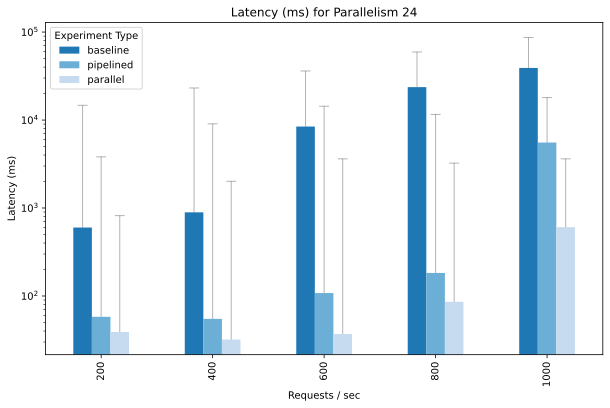

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_mps_vs_latency(preprocessed_df, parallelism_value, relative=False, flink_time=False, add_99=True):
    exps = ['baseline', 'pipelined', 'parallel']
    
    if flink_time:
        v = 'flink_time_median'
    else:
        v = 'latency_median'

    # Filter the preprocessed_df for the given parallelism
    parallelism_df = preprocessed_df[preprocessed_df['parallelism'] == parallelism_value]

    # Filter out mps > 1000
    parallelism_df = parallelism_df[parallelism_df['mps'] <= 1000]

    # Pivot the DataFrame to get the latency values for each experiment type and MPS
    pivot_mps_df = parallelism_df.pivot(index='mps', columns='experiment', values=v)
    pivot_99_df = parallelism_df.pivot(index='mps', columns='experiment', values='latency_99_percentile')

    print(pivot_mps_df.head())
    ylabel = "Latency (ms)"

    if relative:
        # Calculate the relative speedup compared to the base experiment
        pivot_mps_df = pivot_mps_df.div(pivot_mps_df['baseline'], axis=0)
        ylabel = "Relative Latency"
    
    if flink_time:
        ylabel += " (Flink Time)"

    # Plot the data for the given parallelism
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = pivot_mps_df[exps].plot(kind='bar', ax=ax, color=['#1f77b4', '#6baed6', '#c6dbef'])

    if add_99:
        # Add a mark (x) at the midline of each bar, at the height of the 99 percentile
        alpha = 0.3
        for i, ((index, p_99), (_i, median)) in enumerate(zip(pivot_99_df.iterrows(), pivot_mps_df.iterrows())):
            for j, experiment in enumerate(exps):
                x_pos = i + bars.patches[j].get_width() * (j - 1)  # Calculate x position for the "x" mark
                y_99 = p_99[experiment]  # Get the 99th percentile value
                bar_top = median[experiment]
                ax.plot(x_pos, y_99, 'k_', markersize=10, markeredgewidth=1, alpha=alpha)  # Horizontal dash
                ax.vlines(x=x_pos, ymin=bar_top, ymax=y_99, 
                        colors="black", linewidth=1, alpha=alpha)
    
    plt.ylabel(ylabel)
    plt.xlabel('Requests / sec')
    if relative:
        plt.ylim(0, 2)
    else:
        plt.yscale('log')
        pass
        # plt.ylim(0, 1000)
    plt.title(f'{ylabel} for Parallelism {parallelism_value}')
    plt.legend(title='Experiment Type')
    if relative:
        plt.axhline(y=1, color='lightgray', linestyle='--', alpha=0.7)
    plt.savefig("out.svg")
    plt.show()

plot_mps_vs_latency(preprocessed_df, 24, flink_time=False)


experiment     baseline   parallel   pipelined
mps                                           
200          228.648186  30.788779   49.127698
400          553.120494  20.503402   44.006586
600         2086.555958  22.993922   69.686890
800         5131.814718  30.080199  118.370414
1000        5222.234130  54.172277  855.893612
experiment      baseline    parallel    pipelined
mps                                              
200           371.851814    8.211221     8.872302
400           339.879506   11.496598    10.993414
600          6351.444042   14.006078    38.313110
800         18550.185282   55.919801    64.629586
1000        33852.765870  552.827723  4692.106388


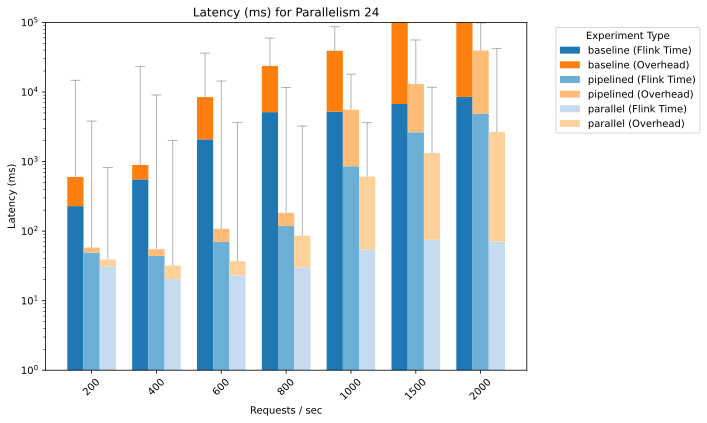

In [57]:
def plot_mps_vs_latency(preprocessed_df, parallelism_value, relative=False, add_99=True):
    exps = ['baseline', 'pipelined', 'parallel']
    
    # Filter the preprocessed_df for the given parallelism
    parallelism_df = preprocessed_df[preprocessed_df['parallelism'] == parallelism_value]

    # Pivot the DataFrame to get the latency values for each experiment type and MPS
    pivot_latency_median_df = parallelism_df.pivot(index='mps', columns='experiment', values='latency_median')
    pivot_flink_time_df = parallelism_df.pivot(index='mps', columns='experiment', values='flink_time_median')
    pivot_99_df = parallelism_df.pivot(index='mps', columns='experiment', values='latency_99_percentile')

    # Calculate overhead
    pivot_overhead_df = pivot_latency_median_df - pivot_flink_time_df

    ylabel = "Latency (ms)"

    if relative:
        # Calculate the relative speedup compared to the base experiment
        pivot_latency_median_df = pivot_latency_median_df.div(pivot_latency_median_df['baseline'], axis=0)
        pivot_flink_time_df = pivot_flink_time_df.div(pivot_flink_time_df['baseline'], axis=0)
        pivot_overhead_df = pivot_overhead_df.div(pivot_overhead_df['baseline'], axis=0)
        ylabel = "Relative Latency"

    # Plot the data for the given parallelism
    fig, ax = plt.subplots(figsize=(10, 6))

    # Colors for flink_time and overhead
    flink_colors = ['#1f77b4', '#6baed6', '#c6dbef']
    overhead_colors = ['#ff7f0e', '#ffbb78', '#ffd19a']

    print(pivot_flink_time_df.head())
    print(pivot_overhead_df.head())
    # Plot stacked bars
    for i, exp in enumerate(exps):
        # Bottom part (flink_time)
        flink_bars = ax.bar(
            [j + (i-1)*0.25 for j in range(len(pivot_latency_median_df))], 
            pivot_flink_time_df[exp], 
            width=0.25, 
            color=flink_colors[i], 
            label=f'{exp} (Flink Time)'
        )
        
        # Top part (overhead)
        overhead_bars = ax.bar(
            [j + (i-1)*0.25 for j in range(len(pivot_latency_median_df))], 
            pivot_overhead_df[exp], 
            width=0.25, 
            bottom=pivot_flink_time_df[exp],
            color=overhead_colors[i], 
            label=f'{exp} (Overhead)'
        )

    if add_99:
        # Add a mark (x) at the midline of each bar, at the height of the 99 percentile
        alpha = 0.3
        for i, ((index, p_99), (_i, median)) in enumerate(zip(pivot_99_df.iterrows(), pivot_latency_median_df.iterrows())):
            for j, experiment in enumerate(exps):
                x_pos = i + 0.25 * (j - 1)  # Calculate x position for the "x" mark
                y_99 = p_99[experiment]  # Get the 99th percentile value
                bar_top = median[experiment]
                ax.plot(x_pos, y_99, 'k_', markersize=10, markeredgewidth=1, alpha=alpha)  # Horizontal dash
                ax.vlines(x=x_pos, ymin=bar_top, ymax=y_99, 
                        colors="black", linewidth=1, alpha=alpha)
    
    plt.ylabel(ylabel)
    plt.xlabel('Requests / sec')
    plt.xticks([j for j in range(len(pivot_latency_median_df))], pivot_latency_median_df.index, rotation=45)
    
    if relative:
        plt.ylim(0, 2)
    else:
        plt.yscale('log')
        plt.ylim(1, 10**5)
    
    plt.title(f'{ylabel} for Parallelism {parallelism_value}')
    plt.legend(title='Experiment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    if relative:
        plt.axhline(y=1, color='lightgray', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Call the function with the desired parallelism
plot_mps_vs_latency(preprocessed_df, 24)

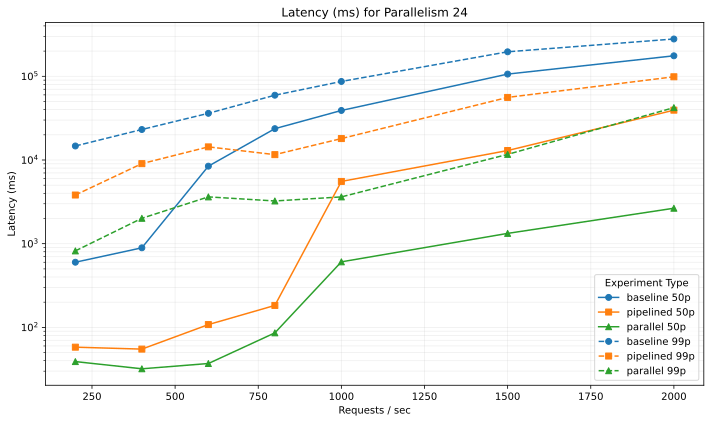

In [55]:
def plot_mps_vs_latency(preprocessed_df, parallelism_value, relative=False, flink_time=False, add_99=True):
    exps = ['baseline', 'pipelined', 'parallel']
    
    # Color palette matching the original graph
    colors = {
        'baseline': '#1f77b4',   # blue
        'pipelined': '#ff7f0e',  # orange
        'parallel': '#2ca02c'    # green
    }
    
    # Marker styles for different experiments
    markers = {
        'baseline': 'o',   # circle
        'pipelined': 's',  # square
        'parallel': '^'    # triangle
    }
   
    if flink_time:
        v_50p = 'flink_time_median'
        v_99p = 'flink_time_99_percentile'
    else:
        v_50p = 'latency_median'
        v_99p = 'latency_99_percentile'
    
    # Filter the preprocessed_df for the given parallelism
    parallelism_df = preprocessed_df[preprocessed_df['parallelism'] == parallelism_value]
    
    # Pivot the DataFrame to get the latency values for each experiment type and MPS
    pivot_mps_50p_df = parallelism_df.pivot(index='mps', columns='experiment', values=v_50p)
    pivot_mps_99p_df = parallelism_df.pivot(index='mps', columns='experiment', values=v_99p)
    
    ylabel = "Latency (ms)"
   
    if flink_time:
        ylabel += " (Flink Time)"
    
    # Plot the data for the given parallelism
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Line plot for 50p values
    for exp in exps:
        ax.plot(pivot_mps_50p_df.index, pivot_mps_50p_df[exp], 
                marker=markers[exp], color=colors[exp], label=f'{exp} 50p')
    
    # Add 99p markers
    if add_99:
        for exp in exps:
            ax.plot(pivot_mps_99p_df.index, pivot_mps_99p_df[exp], 
                    marker=markers[exp], color=colors[exp], 
                    linestyle='--', label=f'{exp} 99p')
   
    plt.ylabel(ylabel)
    plt.xlabel('Requests / sec')
    
  
    plt.yscale('log')
    
    plt.title(f'{ylabel} for Parallelism {parallelism_value}')
    plt.legend(title='Experiment Type')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.tight_layout()
    plt.show()

# Example usage
plot_mps_vs_latency(preprocessed_df, 24, relative=True)

In [6]:
%pip install nbformat

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px


metadata_1={'in_t': 1741340853.944259, 'deser_times': [8.368492126464844e-05, 0.00015592575073242188, 0.0001087188720703125, 0.00010585784912109375, 0.00011086463928222656, 0.00011873245239257812, 0.00012135505676269531], 'flink_time': 0.01974773406982422, 'current_in_t': 1741340853.9663992, 'prof': [('DESERIALIZE DONE', 1741340853.9445667), ('STATELESS OP FILTER: upload_unique_id', 1741340853.945159), ('STATELESS OP ENTRY: upload_unique_id', 1741340853.9451625), ('STATELESS OP INNER ENTRY', 1741340853.945164), ('STATELESS OP EXIT: upload_unique_id', 1741340853.9453297), ('OP STREAM UNION', 1741340853.945723), ('MERGE UNION', 1741340853.9461637), ('INTERNAL SINK', 1741340853.9464107), ('DESERIALIZE DONE', 1741340853.9479232), ('STATEFUL OP FILTER: ComposeReview', 1741340853.9480722), ('STATEFUL OP ENTRY: ComposeReview', 1741340853.9480762), ('STATEFUL OP INNER ENTRY', 1741340853.948569), ('STATEFUL OP EXIT: ComposeReview', 1741340853.948878), ('OP STREAM UNION', 1741340853.9493124), ('MERGE UNION', 1741340853.9501634), ('INTERNAL SINK', 1741340853.950411), ('DESERIALIZE DONE', 1741340853.9516623), ('STATEFUL OP FILTER: User', 1741340853.9519043), ('STATEFUL OP ENTRY: User', 1741340853.9519072), ('STATEFUL OP INNER ENTRY', 1741340853.952173), ('STATEFUL OP EXIT: User', 1741340853.9528432), ('OP STREAM UNION', 1741340853.9533257), ('MERGE UNION', 1741340853.9538383), ('INTERNAL SINK', 1741340853.9541032), ('DESERIALIZE DONE', 1741340853.9552736), ('STATEFUL OP FILTER: ComposeReview', 1741340853.9554212), ('STATEFUL OP ENTRY: ComposeReview', 1741340853.955425), ('STATEFUL OP INNER ENTRY', 1741340853.9556973), ('STATEFUL OP EXIT: ComposeReview', 1741340853.9561088), ('OP STREAM UNION', 1741340853.9568906), ('MERGE UNION', 1741340853.9574006), ('INTERNAL SINK', 1741340853.9576547), ('DESERIALIZE DONE', 1741340853.9586535), ('STATEFUL OP FILTER: MovieId', 1741340853.9594727), ('STATEFUL OP ENTRY: MovieId', 1741340853.9594762), ('STATEFUL OP INNER ENTRY', 1741340853.9598136), ('STATEFUL OP EXIT: MovieId', 1741340853.9605436), ('OP STREAM UNION', 1741340853.9609184), ('MERGE UNION', 1741340853.9613962), ('INTERNAL SINK', 1741340853.9618442), ('DESERIALIZE DONE', 1741340853.9628646), ('STATEFUL OP FILTER: ComposeReview', 1741340853.9630358), ('STATEFUL OP ENTRY: ComposeReview', 1741340853.9630394), ('STATEFUL OP INNER ENTRY', 1741340853.9633222), ('STATEFUL OP EXIT: ComposeReview', 1741340853.963955), ('OP STREAM UNION', 1741340853.9643898), ('MERGE UNION', 1741340853.9651482), ('INTERNAL SINK', 1741340853.9654331), ('DESERIALIZE DONE', 1741340853.9667623), ('STATEFUL OP FILTER: ComposeReview', 1741340853.9669328), ('STATEFUL OP ENTRY: ComposeReview', 1741340853.966937), ('STATEFUL OP INNER ENTRY', 1741340853.96757), ('STATEFUL OP EXIT: ComposeReview', 1741340853.968089), ('OP STREAM UNION', 1741340853.9683769), ('MERGE UNION', 1741340853.9688642), ('EXTERNAL SINK', 1741340853.968978)], 'out_t': 1741340853.9689806, 'loops': 7, 'roundtrip': 0.024721622467041016}
metadata_1_2={'in_t': 1741345029.6665602, 'deser_times': [0.00010704994201660156, 0.00011348724365234375, 0.00011920928955078125, 0.00011682510375976562, 0.00035452842712402344, 0.000125885009765625, 0.00013637542724609375], 'flink_time': 0.01957845687866211, 'current_in_t': 1741345029.6884885, 'prof': [('DESERIALIZE DONE', 1741345029.6670456), ('STATELESS OP FILTER: upload_unique_id', 1741345029.6675959), ('STATELESS OP ENTRY: upload_unique_id', 1741345029.6676002), ('STATELESS OP INNER ENTRY', 1741345029.6676013), ('STATELESS OP EXIT: upload_unique_id', 1741345029.667795), ('OP STREAM UNION', 1741345029.668127), ('MERGE UNION', 1741345029.66881), ('INTERNAL SINK', 1741345029.6690645), ('DESERIALIZE DONE', 1741345029.670202), ('STATEFUL OP FILTER: ComposeReview', 1741345029.6703525), ('STATEFUL OP ENTRY: ComposeReview', 1741345029.6703572), ('STATEFUL OP INNER ENTRY', 1741345029.6713054), ('STATEFUL OP EXIT: ComposeReview', 1741345029.6714745), ('OP STREAM UNION', 1741345029.6717079), ('MERGE UNION', 1741345029.6721876), ('INTERNAL SINK', 1741345029.6724386), ('DESERIALIZE DONE', 1741345029.6736908), ('STATEFUL OP FILTER: User', 1741345029.6739075), ('STATEFUL OP ENTRY: User', 1741345029.673911), ('STATEFUL OP INNER ENTRY', 1741345029.6746142), ('STATEFUL OP EXIT: User', 1741345029.6748044), ('OP STREAM UNION', 1741345029.6750472), ('MERGE UNION', 1741345029.6757264), ('INTERNAL SINK', 1741345029.6760037), ('DESERIALIZE DONE', 1741345029.677054), ('STATEFUL OP FILTER: ComposeReview', 1741345029.677216), ('STATEFUL OP ENTRY: ComposeReview', 1741345029.6772203), ('STATEFUL OP INNER ENTRY', 1741345029.678184), ('STATEFUL OP EXIT: ComposeReview', 1741345029.6783562), ('OP STREAM UNION', 1741345029.678598), ('MERGE UNION', 1741345029.679092), ('INTERNAL SINK', 1741345029.6793575), ('DESERIALIZE DONE', 1741345029.680682), ('STATEFUL OP FILTER: MovieId', 1741345029.6810896), ('STATEFUL OP ENTRY: MovieId', 1741345029.6810925), ('STATEFUL OP INNER ENTRY', 1741345029.6817117), ('STATEFUL OP EXIT: MovieId', 1741345029.6819031), ('OP STREAM UNION', 1741345029.6824057), ('MERGE UNION', 1741345029.6828854), ('INTERNAL SINK', 1741345029.6831393), ('DESERIALIZE DONE', 1741345029.684485), ('STATEFUL OP FILTER: ComposeReview', 1741345029.6846554), ('STATEFUL OP ENTRY: ComposeReview', 1741345029.68466), ('STATEFUL OP INNER ENTRY', 1741345029.6849217), ('STATEFUL OP EXIT: ComposeReview', 1741345029.686158), ('OP STREAM UNION', 1741345029.6868258), ('MERGE UNION', 1741345029.6873412), ('INTERNAL SINK', 1741345029.6877923), ('DESERIALIZE DONE', 1741345029.688879), ('STATEFUL OP FILTER: ComposeReview', 1741345029.689056), ('STATEFUL OP ENTRY: ComposeReview', 1741345029.6890607), ('STATEFUL OP INNER ENTRY', 1741345029.690159), ('STATEFUL OP EXIT: ComposeReview', 1741345029.6903887), ('OP STREAM UNION', 1741345029.6904953), ('MERGE UNION', 1741345029.6906912), ('EXTERNAL SINK', 1741345029.6907463)], 'out_t': 1741345029.6907492, 'loops': 7, 'roundtrip': 0.024188995361328125}
metadata_1_3={'in_t': 1741345136.1867888, 'deser_times': [0.00015425682067871094, 0.00011563301086425781, 0.00011181831359863281, 0.00011682510375976562, 0.00011706352233886719, 0.00012493133544921875, 0.00012493133544921875], 'flink_time': 0.01990675926208496, 'current_in_t': 1741345136.209042, 'prof': [('DESERIALIZE DONE', 1741345136.1871974), ('STATELESS OP FILTER: upload_unique_id', 1741345136.1879072), ('STATELESS OP ENTRY: upload_unique_id', 1741345136.18791), ('STATELESS OP INNER ENTRY', 1741345136.1879108), ('STATELESS OP EXIT: upload_unique_id', 1741345136.1880774), ('OP STREAM UNION', 1741345136.1884012), ('MERGE UNION', 1741345136.188874), ('INTERNAL SINK', 1741345136.1892276), ('DESERIALIZE DONE', 1741345136.1903949), ('STATEFUL OP FILTER: ComposeReview', 1741345136.1905456), ('STATEFUL OP ENTRY: ComposeReview', 1741345136.1905487), ('STATEFUL OP INNER ENTRY', 1741345136.1909106), ('STATEFUL OP EXIT: ComposeReview', 1741345136.191669), ('OP STREAM UNION', 1741345136.1921008), ('MERGE UNION', 1741345136.1925726), ('INTERNAL SINK', 1741345136.192795), ('DESERIALIZE DONE', 1741345136.1940606), ('STATEFUL OP FILTER: User', 1741345136.1944313), ('STATEFUL OP ENTRY: User', 1741345136.1944342), ('STATEFUL OP INNER ENTRY', 1741345136.1946955), ('STATEFUL OP EXIT: User', 1741345136.195438), ('OP STREAM UNION', 1741345136.1956966), ('MERGE UNION', 1741345136.1963673), ('INTERNAL SINK', 1741345136.1965857), ('DESERIALIZE DONE', 1741345136.1976435), ('STATEFUL OP FILTER: ComposeReview', 1741345136.1977835), ('STATEFUL OP ENTRY: ComposeReview', 1741345136.1977868), ('STATEFUL OP INNER ENTRY', 1741345136.198143), ('STATEFUL OP EXIT: ComposeReview', 1741345136.1990201), ('OP STREAM UNION', 1741345136.1993158), ('MERGE UNION', 1741345136.1998112), ('INTERNAL SINK', 1741345136.200042), ('DESERIALIZE DONE', 1741345136.2011697), ('STATEFUL OP FILTER: MovieId', 1741345136.2016988), ('STATEFUL OP ENTRY: MovieId', 1741345136.2017014), ('STATEFUL OP INNER ENTRY', 1741345136.2020621), ('STATEFUL OP EXIT: MovieId', 1741345136.2025616), ('OP STREAM UNION', 1741345136.2028227), ('MERGE UNION', 1741345136.2039819), ('INTERNAL SINK', 1741345136.2042394), ('DESERIALIZE DONE', 1741345136.2054622), ('STATEFUL OP FILTER: ComposeReview', 1741345136.2056322), ('STATEFUL OP ENTRY: ComposeReview', 1741345136.2056358), ('STATEFUL OP INNER ENTRY', 1741345136.205915), ('STATEFUL OP EXIT: ComposeReview', 1741345136.2065644), ('OP STREAM UNION', 1741345136.2070503), ('MERGE UNION', 1741345136.207916), ('INTERNAL SINK', 1741345136.2082431), ('DESERIALIZE DONE', 1741345136.2096508), ('STATEFUL OP FILTER: ComposeReview', 1741345136.2098272), ('STATEFUL OP ENTRY: ComposeReview', 1741345136.20983), ('STATEFUL OP INNER ENTRY', 1741345136.210305), ('STATEFUL OP EXIT: ComposeReview', 1741345136.2108014), ('OP STREAM UNION', 1741345136.2110453), ('MERGE UNION', 1741345136.211527), ('EXTERNAL SINK', 1741345136.2115817)], 'out_t': 1741345136.2115839, 'loops': 7, 'roundtrip': 0.024795055389404297}
metadata_1_4={'in_t': 1741345215.011204, 'deser_times': [0.00010418891906738281, 0.00010728836059570312, 0.00010633468627929688, 0.00010895729064941406, 0.00010967254638671875, 0.00011587142944335938, 0.000125885009765625], 'flink_time': 0.01892542839050293, 'current_in_t': 1741345215.0330958, 'prof': [('DESERIALIZE DONE', 1741345215.011536), ('STATELESS OP FILTER: upload_unique_id', 1741345215.0122664), ('STATELESS OP ENTRY: upload_unique_id', 1741345215.0122697), ('STATELESS OP INNER ENTRY', 1741345215.0122714), ('STATELESS OP EXIT: upload_unique_id', 1741345215.012436), ('OP STREAM UNION', 1741345215.0126247), ('MERGE UNION', 1741345215.0134099), ('INTERNAL SINK', 1741345215.0136352), ('DESERIALIZE DONE', 1741345215.014866), ('STATEFUL OP FILTER: ComposeReview', 1741345215.0150316), ('STATEFUL OP ENTRY: ComposeReview', 1741345215.0150373), ('STATEFUL OP INNER ENTRY', 1741345215.015958), ('STATEFUL OP EXIT: ComposeReview', 1741345215.0163817), ('OP STREAM UNION', 1741345215.0166078), ('MERGE UNION', 1741345215.0170515), ('INTERNAL SINK', 1741345215.0173397), ('DESERIALIZE DONE', 1741345215.0183642), ('STATEFUL OP FILTER: User', 1741345215.0187438), ('STATEFUL OP ENTRY: User', 1741345215.0187466), ('STATEFUL OP INNER ENTRY', 1741345215.0190558), ('STATEFUL OP EXIT: User', 1741345215.0196342), ('OP STREAM UNION', 1741345215.0198426), ('MERGE UNION', 1741345215.0203907), ('INTERNAL SINK', 1741345215.0206325), ('DESERIALIZE DONE', 1741345215.0220318), ('STATEFUL OP FILTER: ComposeReview', 1741345215.022178), ('STATEFUL OP ENTRY: ComposeReview', 1741345215.0221822), ('STATEFUL OP INNER ENTRY', 1741345215.0224342), ('STATEFUL OP EXIT: ComposeReview', 1741345215.0230677), ('OP STREAM UNION', 1741345215.0234475), ('MERGE UNION', 1741345215.024222), ('INTERNAL SINK', 1741345215.0244777), ('DESERIALIZE DONE', 1741345215.025797), ('STATEFUL OP FILTER: MovieId', 1741345215.026194), ('STATEFUL OP ENTRY: MovieId', 1741345215.026197), ('STATEFUL OP INNER ENTRY', 1741345215.0264661), ('STATEFUL OP EXIT: MovieId', 1741345215.0269072), ('OP STREAM UNION', 1741345215.0272555), ('MERGE UNION', 1741345215.0279589), ('INTERNAL SINK', 1741345215.0282168), ('DESERIALIZE DONE', 1741345215.0294828), ('STATEFUL OP FILTER: ComposeReview', 1741345215.029651), ('STATEFUL OP ENTRY: ComposeReview', 1741345215.029655), ('STATEFUL OP INNER ENTRY', 1741345215.0299277), ('STATEFUL OP EXIT: ComposeReview', 1741345215.0302699), ('OP STREAM UNION', 1741345215.0309997), ('MERGE UNION', 1741345215.031869), ('INTERNAL SINK', 1741345215.0323083), ('DESERIALIZE DONE', 1741345215.0334575), ('STATEFUL OP FILTER: ComposeReview', 1741345215.033633), ('STATEFUL OP ENTRY: ComposeReview', 1741345215.0336368), ('STATEFUL OP INNER ENTRY', 1741345215.033916), ('STATEFUL OP EXIT: ComposeReview', 1741345215.034309), ('OP STREAM UNION', 1741345215.0346293), ('MERGE UNION', 1741345215.0352788), ('EXTERNAL SINK', 1741345215.0353367)], 'out_t': 1741345215.0353398, 'loops': 7, 'roundtrip': 0.024135828018188477}

metadata_16={'in_t': 1741340978.8142116, 'deser_times': [0.00014472007751464844, 0.00015783309936523438, 0.00013017654418945312, 0.00016999244689941406, 0.00013780593872070312, 0.00014829635620117188, 0.00015115737915039062], 'flink_time': 0.0344548225402832, 'current_in_t': 1741340978.8519905, 'prof': [('DESERIALIZE DONE', 1741340978.8146741), ('STATELESS OP FILTER: upload_unique_id', 1741340978.8154), ('STATELESS OP ENTRY: upload_unique_id', 1741340978.8154042), ('STATELESS OP INNER ENTRY', 1741340978.815407), ('STATELESS OP EXIT: upload_unique_id', 1741340978.8155909), ('OP STREAM UNION', 1741340978.815871), ('MERGE UNION', 1741340978.8168077), ('INTERNAL SINK', 1741340978.8171427), ('DESERIALIZE DONE', 1741340978.8188162), ('STATEFUL OP FILTER: ComposeReview', 1741340978.8189914), ('STATEFUL OP ENTRY: ComposeReview', 1741340978.818998), ('STATEFUL OP INNER ENTRY', 1741340978.8203533), ('STATEFUL OP EXIT: ComposeReview', 1741340978.8208542), ('OP STREAM UNION', 1741340978.8213038), ('MERGE UNION', 1741340978.8219073), ('INTERNAL SINK', 1741340978.8224676), ('DESERIALIZE DONE', 1741340978.823684), ('STATEFUL OP FILTER: User', 1741340978.823958), ('STATEFUL OP ENTRY: User', 1741340978.8239613), ('STATEFUL OP INNER ENTRY', 1741340978.8253636), ('STATEFUL OP EXIT: User', 1741340978.825724), ('OP STREAM UNION', 1741340978.8261878), ('MERGE UNION', 1741340978.8270056), ('INTERNAL SINK', 1741340978.8274398), ('DESERIALIZE DONE', 1741340978.828914), ('STATEFUL OP FILTER: ComposeReview', 1741340978.8291109), ('STATEFUL OP ENTRY: ComposeReview', 1741340978.8291159), ('STATEFUL OP INNER ENTRY', 1741340978.8303058), ('STATEFUL OP EXIT: ComposeReview', 1741340978.8305194), ('OP STREAM UNION', 1741340978.830866), ('MERGE UNION', 1741340978.8315067), ('INTERNAL SINK', 1741340978.832099), ('DESERIALIZE DONE', 1741340978.8333282), ('STATEFUL OP FILTER: MovieId', 1741340978.833782), ('STATEFUL OP ENTRY: MovieId', 1741340978.833785), ('STATEFUL OP INNER ENTRY', 1741340978.8351867), ('STATEFUL OP EXIT: MovieId', 1741340978.835432), ('OP STREAM UNION', 1741340978.8359835), ('MERGE UNION', 1741340978.8365932), ('INTERNAL SINK', 1741340978.8369086), ('DESERIALIZE DONE', 1741340978.838153), ('STATEFUL OP FILTER: ComposeReview', 1741340978.838332), ('STATEFUL OP ENTRY: ComposeReview', 1741340978.8383372), ('STATEFUL OP INNER ENTRY', 1741340978.8389423), ('STATEFUL OP EXIT: ComposeReview', 1741340978.8482368), ('OP STREAM UNION', 1741340978.8490171), ('MERGE UNION', 1741340978.8502772), ('INTERNAL SINK', 1741340978.8506262), ('DESERIALIZE DONE', 1741340978.8524442), ('STATEFUL OP FILTER: ComposeReview', 1741340978.8526635), ('STATEFUL OP ENTRY: ComposeReview', 1741340978.8526688), ('STATEFUL OP INNER ENTRY', 1741340978.853051), ('STATEFUL OP EXIT: ComposeReview', 1741340978.8535786), ('OP STREAM UNION', 1741340978.8538923), ('MERGE UNION', 1741340978.854686), ('EXTERNAL SINK', 1741340978.8547628)], 'out_t': 1741340978.854769, 'loops': 7, 'roundtrip': 0.0405573844909668}                                                                                                               
metadata_16_2={'in_t': 1741341523.0177526, 'deser_times': [0.000125885009765625, 0.00015497207641601562, 0.00014710426330566406, 0.00015473365783691406, 0.0001685619354248047, 0.0001647472381591797, 0.0001761913299560547], 'flink_time': 0.03346419334411621, 'current_in_t': 1741341523.0643687, 'prof': [('DESERIALIZE DONE', 1741341523.0180964), ('STATELESS OP FILTER: upload_unique_id', 1741341523.0187778), ('STATELESS OP ENTRY: upload_unique_id', 1741341523.0187824), ('STATELESS OP INNER ENTRY', 1741341523.018785), ('STATELESS OP EXIT: upload_unique_id', 1741341523.0189674), ('OP STREAM UNION', 1741341523.0192635), ('MERGE UNION', 1741341523.0203717), ('INTERNAL SINK', 1741341523.0206816), ('DESERIALIZE DONE', 1741341523.022198), ('STATEFUL OP FILTER: ComposeReview', 1741341523.0223827), ('STATEFUL OP ENTRY: ComposeReview', 1741341523.022388), ('STATEFUL OP INNER ENTRY', 1741341523.0234098), ('STATEFUL OP EXIT: ComposeReview', 1741341523.0240622), ('OP STREAM UNION', 1741341523.024596), ('MERGE UNION', 1741341523.0259192), ('INTERNAL SINK', 1741341523.026573), ('DESERIALIZE DONE', 1741341523.0385458), ('STATEFUL OP FILTER: User', 1741341523.038859), ('STATEFUL OP ENTRY: User', 1741341523.0388641), ('STATEFUL OP INNER ENTRY', 1741341523.0401804), ('STATEFUL OP EXIT: User', 1741341523.0403707), ('OP STREAM UNION', 1741341523.0407495), ('MERGE UNION', 1741341523.0414484), ('INTERNAL SINK', 1741341523.041793), ('DESERIALIZE DONE', 1741341523.0432227), ('STATEFUL OP FILTER: ComposeReview', 1741341523.043414), ('STATEFUL OP ENTRY: ComposeReview', 1741341523.043419), ('STATEFUL OP INNER ENTRY', 1741341523.0499682), ('STATEFUL OP EXIT: ComposeReview', 1741341523.0509837), ('OP STREAM UNION', 1741341523.0516355), ('MERGE UNION', 1741341523.052267), ('INTERNAL SINK', 1741341523.052892), ('DESERIALIZE DONE', 1741341523.0542734), ('STATEFUL OP FILTER: MovieId', 1741341523.0548112), ('STATEFUL OP ENTRY: MovieId', 1741341523.0548155), ('STATEFUL OP INNER ENTRY', 1741341523.0553129), ('STATEFUL OP EXIT: MovieId', 1741341523.0563173), ('OP STREAM UNION', 1741341523.0568535), ('MERGE UNION', 1741341523.057671), ('INTERNAL SINK', 1741341523.0580542), ('DESERIALIZE DONE', 1741341523.059455), ('STATEFUL OP FILTER: ComposeReview', 1741341523.0596557), ('STATEFUL OP ENTRY: ComposeReview', 1741341523.0596614), ('STATEFUL OP INNER ENTRY', 1741341523.0615768), ('STATEFUL OP EXIT: ComposeReview', 1741341523.0617847), ('OP STREAM UNION', 1741341523.0621397), ('MERGE UNION', 1741341523.0632343), ('INTERNAL SINK', 1741341523.0635335), ('DESERIALIZE DONE', 1741341523.064886), ('STATEFUL OP FILTER: ComposeReview', 1741341523.065102), ('STATEFUL OP ENTRY: ComposeReview', 1741341523.065108), ('STATEFUL OP INNER ENTRY', 1741341523.0656972), ('STATEFUL OP EXIT: ComposeReview', 1741341523.0668292), ('OP STREAM UNION', 1741341523.0670438), ('MERGE UNION', 1741341523.0673115), ('EXTERNAL SINK', 1741341523.067398)], 'out_t': 1741341523.0674047, 'loops': 7, 'roundtrip': 0.049652099609375}
metadata_16_3={'in_t': 1741344365.2194037, 'deser_times': [0.00013113021850585938, 0.0001475811004638672, 0.00020647048950195312, 0.0001773834228515625, 0.0001761913299560547, 0.00017380714416503906, 0.00019025802612304688], 'flink_time': 0.024364709854125977, 'current_in_t': 1741344365.2461896, 'prof': [('DESERIALIZE DONE', 1741344365.219819), ('STATELESS OP FILTER: upload_unique_id', 1741344365.2206218), ('STATELESS OP ENTRY: upload_unique_id', 1741344365.2206256), ('STATELESS OP INNER ENTRY', 1741344365.2206268), ('STATELESS OP EXIT: upload_unique_id', 1741344365.22082), ('OP STREAM UNION', 1741344365.221229), ('MERGE UNION', 1741344365.2217474), ('INTERNAL SINK', 1741344365.2222164), ('DESERIALIZE DONE', 1741344365.2236989), ('STATEFUL OP FILTER: ComposeReview', 1741344365.2239237), ('STATEFUL OP ENTRY: ComposeReview', 1741344365.2239304), ('STATEFUL OP INNER ENTRY', 1741344365.2250307), ('STATEFUL OP EXIT: ComposeReview', 1741344365.2256093), ('OP STREAM UNION', 1741344365.2259424), ('MERGE UNION', 1741344365.226517), ('INTERNAL SINK', 1741344365.2268004), ('DESERIALIZE DONE', 1741344365.2283034), ('STATEFUL OP FILTER: User', 1741344365.228836), ('STATEFUL OP ENTRY: User', 1741344365.2288396), ('STATEFUL OP INNER ENTRY', 1741344365.2298803), ('STATEFUL OP EXIT: User', 1741344365.2302575), ('OP STREAM UNION', 1741344365.230654), ('MERGE UNION', 1741344365.231545), ('INTERNAL SINK', 1741344365.2318177), ('DESERIALIZE DONE', 1741344365.233417), ('STATEFUL OP FILTER: ComposeReview', 1741344365.2336116), ('STATEFUL OP ENTRY: ComposeReview', 1741344365.233617), ('STATEFUL OP INNER ENTRY', 1741344365.2340834), ('STATEFUL OP EXIT: ComposeReview', 1741344365.2349212), ('OP STREAM UNION', 1741344365.235211), ('MERGE UNION', 1741344365.235816), ('INTERNAL SINK', 1741344365.2361062), ('DESERIALIZE DONE', 1741344365.237368), ('STATEFUL OP FILTER: MovieId', 1741344365.238407), ('STATEFUL OP ENTRY: MovieId', 1741344365.238411), ('STATEFUL OP INNER ENTRY', 1741344365.239219), ('STATEFUL OP EXIT: MovieId', 1741344365.23952), ('OP STREAM UNION', 1741344365.2399988), ('MERGE UNION', 1741344365.240907), ('INTERNAL SINK', 1741344365.2412553), ('DESERIALIZE DONE', 1741344365.2425647), ('STATEFUL OP FILTER: ComposeReview', 1741344365.2427657), ('STATEFUL OP ENTRY: ComposeReview', 1741344365.2427742), ('STATEFUL OP INNER ENTRY', 1741344365.2431428), ('STATEFUL OP EXIT: ComposeReview', 1741344365.2437308), ('OP STREAM UNION', 1741344365.2444031), ('MERGE UNION', 1741344365.2449937), ('INTERNAL SINK', 1741344365.245312), ('DESERIALIZE DONE', 1741344365.2470772), ('STATEFUL OP FILTER: ComposeReview', 1741344365.2472951), ('STATEFUL OP ENTRY: ComposeReview', 1741344365.2473009), ('STATEFUL OP INNER ENTRY', 1741344365.2479227), ('STATEFUL OP EXIT: ComposeReview', 1741344365.2484355), ('OP STREAM UNION', 1741344365.2489393), ('MERGE UNION', 1741344365.249201), ('EXTERNAL SINK', 1741344365.2492704)], 'out_t': 1741344365.2492752, 'loops': 7, 'roundtrip': 0.029871463775634766}
metadata_16_4={'in_t': 1741344667.9428053, 'deser_times': [0.00012445449829101562, 0.00014638900756835938, 0.00014281272888183594, 0.00048804283142089844, 0.0001633167266845703, 0.0001761913299560547, 0.00017261505126953125], 'flink_time': 0.03505229949951172, 'current_in_t': 1741344667.9818714, 'prof': [('DESERIALIZE DONE', 1741344667.943239), ('STATELESS OP FILTER: upload_unique_id', 1741344667.944236), ('STATELESS OP ENTRY: upload_unique_id', 1741344667.9442418), ('STATELESS OP INNER ENTRY', 1741344667.9442437), ('STATELESS OP EXIT: upload_unique_id', 1741344667.9444413), ('OP STREAM UNION', 1741344667.944831), ('MERGE UNION', 1741344667.9453256), ('INTERNAL SINK', 1741344667.9455698), ('DESERIALIZE DONE', 1741344667.9472594), ('STATEFUL OP FILTER: ComposeReview', 1741344667.9474206), ('STATEFUL OP ENTRY: ComposeReview', 1741344667.9474275), ('STATEFUL OP INNER ENTRY', 1741344667.94844), ('STATEFUL OP EXIT: ComposeReview', 1741344667.94872), ('OP STREAM UNION', 1741344667.949028), ('MERGE UNION', 1741344667.9499426), ('INTERNAL SINK', 1741344667.9503024), ('DESERIALIZE DONE', 1741344667.9516726), ('STATEFUL OP FILTER: User', 1741344667.9519746), ('STATEFUL OP ENTRY: User', 1741344667.9519787), ('STATEFUL OP INNER ENTRY', 1741344667.9530196), ('STATEFUL OP EXIT: User', 1741344667.9536002), ('OP STREAM UNION', 1741344667.9540396), ('MERGE UNION', 1741344667.9547286), ('INTERNAL SINK', 1741344667.9550526), ('DESERIALIZE DONE', 1741344667.9568696), ('STATEFUL OP FILTER: ComposeReview', 1741344667.957072), ('STATEFUL OP ENTRY: ComposeReview', 1741344667.9570782), ('STATEFUL OP INNER ENTRY', 1741344667.9581196), ('STATEFUL OP EXIT: ComposeReview', 1741344667.958305), ('OP STREAM UNION', 1741344667.9596906), ('MERGE UNION', 1741344667.9654672), ('INTERNAL SINK', 1741344667.9657955), ('DESERIALIZE DONE', 1741344667.967748), ('STATEFUL OP FILTER: MovieId', 1741344667.9684858), ('STATEFUL OP ENTRY: MovieId', 1741344667.9684896), ('STATEFUL OP INNER ENTRY', 1741344667.968998), ('STATEFUL OP EXIT: MovieId', 1741344667.969515), ('OP STREAM UNION', 1741344667.970159), ('MERGE UNION', 1741344667.9708884), ('INTERNAL SINK', 1741344667.971525), ('DESERIALIZE DONE', 1741344667.9734738), ('STATEFUL OP FILTER: ComposeReview', 1741344667.9736738), ('STATEFUL OP ENTRY: ComposeReview', 1741344667.9736795), ('STATEFUL OP INNER ENTRY', 1741344667.978133), ('STATEFUL OP EXIT: ComposeReview', 1741344667.9789157), ('OP STREAM UNION', 1741344667.9794633), ('MERGE UNION', 1741344667.9801977), ('INTERNAL SINK', 1741344667.980689), ('DESERIALIZE DONE', 1741344667.9823337), ('STATEFUL OP FILTER: ComposeReview', 1741344667.9825354), ('STATEFUL OP ENTRY: ComposeReview', 1741344667.982541), ('STATEFUL OP INNER ENTRY', 1741344667.983158), ('STATEFUL OP EXIT: ComposeReview', 1741344667.9842753), ('OP STREAM UNION', 1741344667.9844167), ('MERGE UNION', 1741344667.9846835), ('EXTERNAL SINK', 1741344667.984767)], 'out_t': 1741344667.9847746, 'loops': 7, 'roundtrip': 0.04196929931640625}


metadata_process_mode={'in_t': 1741345723.6207886, 'deser_times': [0.00012493133544921875, 0.00012540817260742188, 0.0001404285430908203, 0.00014066696166992188, 0.00014090538024902344, 0.0001380443572998047, 0.000171661376953125], 'flink_time': 0.25135111808776855, 'current_in_t': 1741345723.87257, 'prof': [('DESERIALIZE DONE', 1741345723.6233344), ('STATELESS OP FILTER: upload_unique_id', 1741345723.6397939), ('STATELESS OP ENTRY: upload_unique_id', 1741345723.639832), ('STATELESS OP INNER ENTRY', 1741345723.639851), ('STATELESS OP EXIT: upload_unique_id', 1741345723.6403065), ('OP STREAM UNION', 1741345723.642999), ('MERGE UNION', 1741345723.6502597), ('INTERNAL SINK', 1741345723.6530893), ('DESERIALIZE DONE', 1741345723.6602619), ('STATEFUL OP FILTER: ComposeReview', 1741345723.6685889), ('STATEFUL OP ENTRY: ComposeReview', 1741345723.6686049), ('STATEFUL OP INNER ENTRY', 1741345723.6724267), ('STATEFUL OP EXIT: ComposeReview', 1741345723.6745338), ('OP STREAM UNION', 1741345723.678512), ('MERGE UNION', 1741345723.6841962), ('INTERNAL SINK', 1741345723.6868606), ('DESERIALIZE DONE', 1741345723.6979504), ('STATEFUL OP FILTER: User', 1741345723.7072885), ('STATEFUL OP ENTRY: User', 1741345723.7073026), ('STATEFUL OP INNER ENTRY', 1741345723.7107346), ('STATEFUL OP EXIT: User', 1741345723.7111442), ('OP STREAM UNION', 1741345723.7170517), ('MERGE UNION', 1741345723.729725), ('INTERNAL SINK', 1741345723.7328098), ('DESERIALIZE DONE', 1741345723.7403693), ('STATEFUL OP FILTER: ComposeReview', 1741345723.7478952), ('STATEFUL OP ENTRY: ComposeReview', 1741345723.747911), ('STATEFUL OP INNER ENTRY', 1741345723.752177), ('STATEFUL OP EXIT: ComposeReview', 1741345723.7524743), ('OP STREAM UNION', 1741345723.75773), ('MERGE UNION', 1741345723.763841), ('INTERNAL SINK', 1741345723.7674856), ('DESERIALIZE DONE', 1741345723.7752402), ('STATEFUL OP FILTER: MovieId', 1741345723.806223), ('STATEFUL OP ENTRY: MovieId', 1741345723.806247), ('STATEFUL OP INNER ENTRY', 1741345723.8100455), ('STATEFUL OP EXIT: MovieId', 1741345723.8104894), ('OP STREAM UNION', 1741345723.818641), ('MERGE UNION', 1741345723.827667), ('INTERNAL SINK', 1741345723.832121), ('DESERIALIZE DONE', 1741345723.8402433), ('STATEFUL OP FILTER: ComposeReview', 1741345723.848333), ('STATEFUL OP ENTRY: ComposeReview', 1741345723.848358), ('STATEFUL OP INNER ENTRY', 1741345723.8523293), ('STATEFUL OP EXIT: ComposeReview', 1741345723.852732), ('OP STREAM UNION', 1741345723.8578298), ('MERGE UNION', 1741345723.8640106), ('INTERNAL SINK', 1741345723.8665187), ('DESERIALIZE DONE', 1741345723.8783383), ('STATEFUL OP FILTER: ComposeReview', 1741345723.8860836), ('STATEFUL OP ENTRY: ComposeReview', 1741345723.8860974), ('STATEFUL OP INNER ENTRY', 1741345723.8876092), ('STATEFUL OP EXIT: ComposeReview', 1741345723.8884163), ('OP STREAM UNION', 1741345723.8926568), ('MERGE UNION', 1741345723.8988156), ('EXTERNAL SINK', 1741345723.9035068)], 'out_t': 1741345723.9035182, 'loops': 7, 'roundtrip': 0.2827296257019043}
metadata_process_mode_2={'in_t': 1741346720.669457, 'deser_times': [0.00014519691467285156, 0.00013685226440429688, 0.0001342296600341797, 0.00013113021850585938, 0.00015306472778320312, 0.00012683868408203125, 0.00016736984252929688], 'flink_time': 0.28320813179016113, 'current_in_t': 1741346720.9480562, 'prof': [('DESERIALIZE DONE', 1741346720.6743693), ('STATELESS OP FILTER: upload_unique_id', 1741346720.6942685), ('STATELESS OP ENTRY: upload_unique_id', 1741346720.6942973), ('STATELESS OP INNER ENTRY', 1741346720.6943064), ('STATELESS OP EXIT: upload_unique_id', 1741346720.694706), ('OP STREAM UNION', 1741346720.6972914), ('MERGE UNION', 1741346720.706518), ('INTERNAL SINK', 1741346720.711334), ('DESERIALIZE DONE', 1741346720.7162967), ('STATEFUL OP FILTER: ComposeReview', 1741346720.7311423), ('STATEFUL OP ENTRY: ComposeReview', 1741346720.7311656), ('STATEFUL OP INNER ENTRY', 1741346720.7354589), ('STATEFUL OP EXIT: ComposeReview', 1741346720.7369764), ('OP STREAM UNION', 1741346720.739964), ('MERGE UNION', 1741346720.7489722), ('INTERNAL SINK', 1741346720.7529962), ('DESERIALIZE DONE', 1741346720.7610784), ('STATEFUL OP FILTER: User', 1741346720.7831135), ('STATEFUL OP ENTRY: User', 1741346720.7831345), ('STATEFUL OP INNER ENTRY', 1741346720.7854745), ('STATEFUL OP EXIT: User', 1741346720.7859335), ('OP STREAM UNION', 1741346720.790023), ('MERGE UNION', 1741346720.7965348), ('INTERNAL SINK', 1741346720.8017335), ('DESERIALIZE DONE', 1741346720.8110464), ('STATEFUL OP FILTER: ComposeReview', 1741346720.82946), ('STATEFUL OP ENTRY: ComposeReview', 1741346720.8294828), ('STATEFUL OP INNER ENTRY', 1741346720.8306882), ('STATEFUL OP EXIT: ComposeReview', 1741346720.8309004), ('OP STREAM UNION', 1741346720.8341742), ('MERGE UNION', 1741346720.8438976), ('INTERNAL SINK', 1741346720.8482308), ('DESERIALIZE DONE', 1741346720.8560925), ('STATEFUL OP FILTER: MovieId', 1741346720.8666916), ('STATEFUL OP ENTRY: MovieId', 1741346720.8667173), ('STATEFUL OP INNER ENTRY', 1741346720.8704276), ('STATEFUL OP EXIT: MovieId', 1741346720.8708012), ('OP STREAM UNION', 1741346720.8746703), ('MERGE UNION', 1741346720.8812883), ('INTERNAL SINK', 1741346720.8888233), ('DESERIALIZE DONE', 1741346720.9060962), ('STATEFUL OP FILTER: ComposeReview', 1741346720.9221535), ('STATEFUL OP ENTRY: ComposeReview', 1741346720.922174), ('STATEFUL OP INNER ENTRY', 1741346720.925401), ('STATEFUL OP EXIT: ComposeReview', 1741346720.9256046), ('OP STREAM UNION', 1741346720.9292088), ('MERGE UNION', 1741346720.9389548), ('INTERNAL SINK', 1741346720.9428518), ('DESERIALIZE DONE', 1741346720.9510946), ('STATEFUL OP FILTER: ComposeReview', 1741346720.9692218), ('STATEFUL OP ENTRY: ComposeReview', 1741346720.9692414), ('STATEFUL OP INNER ENTRY', 1741346720.9705293), ('STATEFUL OP EXIT: ComposeReview', 1741346720.9711804), ('OP STREAM UNION', 1741346720.974113), ('MERGE UNION', 1741346720.9837584), ('EXTERNAL SINK', 1741346720.9905028)], 'out_t': 1741346720.9905148, 'loops': 7, 'roundtrip': 0.3210577964782715}
metadata_process_mode_3={'in_t': 1741348060.4612477, 'deser_times': [0.00012421607971191406, 0.00013446807861328125, 0.0001380443572998047, 0.00011730194091796875, 0.00014781951904296875, 0.00013327598571777344, 0.00010704994201660156], 'flink_time': 0.314241886138916, 'current_in_t': 1741348060.7623138, 'prof': [('DESERIALIZE DONE', 1741348060.4669175), ('STATELESS OP FILTER: upload_unique_id', 1741348060.4838452), ('STATELESS OP ENTRY: upload_unique_id', 1741348060.4838772), ('STATELESS OP INNER ENTRY', 1741348060.4838858), ('STATELESS OP EXIT: upload_unique_id', 1741348060.4843004), ('OP STREAM UNION', 1741348060.4857504), ('MERGE UNION', 1741348060.4935832), ('INTERNAL SINK', 1741348060.4993625), ('DESERIALIZE DONE', 1741348060.5060847), ('STATEFUL OP FILTER: ComposeReview', 1741348060.529873), ('STATEFUL OP ENTRY: ComposeReview', 1741348060.5298977), ('STATEFUL OP INNER ENTRY', 1741348060.5335183), ('STATEFUL OP EXIT: ComposeReview', 1741348060.5351913), ('OP STREAM UNION', 1741348060.5397878), ('MERGE UNION', 1741348060.5483263), ('INTERNAL SINK', 1741348060.5526438), ('DESERIALIZE DONE', 1741348060.5611885), ('STATEFUL OP FILTER: User', 1741348060.5719175), ('STATEFUL OP ENTRY: User', 1741348060.5719335), ('STATEFUL OP INNER ENTRY', 1741348060.5744228), ('STATEFUL OP EXIT: User', 1741348060.5747545), ('OP STREAM UNION', 1741348060.5822966), ('MERGE UNION', 1741348060.587228), ('INTERNAL SINK', 1741348060.5938127), ('DESERIALIZE DONE', 1741348060.601108), ('STATEFUL OP FILTER: ComposeReview', 1741348060.6243763), ('STATEFUL OP ENTRY: ComposeReview', 1741348060.6243925), ('STATEFUL OP INNER ENTRY', 1741348060.6283448), ('STATEFUL OP EXIT: ComposeReview', 1741348060.6285734), ('OP STREAM UNION', 1741348060.6346943), ('MERGE UNION', 1741348060.6386135), ('INTERNAL SINK', 1741348060.6460419), ('DESERIALIZE DONE', 1741348060.656145), ('STATEFUL OP FILTER: MovieId', 1741348060.6726635), ('STATEFUL OP ENTRY: MovieId', 1741348060.6726806), ('STATEFUL OP INNER ENTRY', 1741348060.6764872), ('STATEFUL OP EXIT: MovieId', 1741348060.676978), ('OP STREAM UNION', 1741348060.6854794), ('MERGE UNION', 1741348060.6947064), ('INTERNAL SINK', 1741348060.6999812), ('DESERIALIZE DONE', 1741348060.71628), ('STATEFUL OP FILTER: ComposeReview', 1741348060.7398047), ('STATEFUL OP ENTRY: ComposeReview', 1741348060.7398238), ('STATEFUL OP INNER ENTRY', 1741348060.7433884), ('STATEFUL OP EXIT: ComposeReview', 1741348060.7436047), ('OP STREAM UNION', 1741348060.749739), ('MERGE UNION', 1741348060.7535958), ('INTERNAL SINK', 1741348060.760411), ('DESERIALIZE DONE', 1741348060.7662022), ('STATEFUL OP FILTER: ComposeReview', 1741348060.789065), ('STATEFUL OP ENTRY: ComposeReview', 1741348060.7890806), ('STATEFUL OP INNER ENTRY', 1741348060.7933474), ('STATEFUL OP EXIT: ComposeReview', 1741348060.7936218), ('OP STREAM UNION', 1741348060.7996016), ('MERGE UNION', 1741348060.8032722), ('EXTERNAL SINK', 1741348060.806702)], 'out_t': 1741348060.8067107, 'loops': 7, 'roundtrip': 0.3454630374908447}

def analyze(metadata_list):
    all_events = []
    for idx, metadata in enumerate(metadata_list):
        events = metadata["prof"]
        for i in range(1, len(events)):
            start_event = events[i-1]
            end_event = events[i]
            duration = (end_event[1] - start_event[1]) * 1000  # Convert to milliseconds
            all_events.append({
                "Metadata": f"Metadata {idx+1}",
                "Event": end_event[0],
                "Start": start_event[1] - events[0][1],
                "Duration": duration
            })
    
    df = pd.DataFrame(all_events)
    df = df.sort_values(by=["Metadata", "Start"])  # Ensure chronological order per Metadata
    
    # Create grouped color mapping
    stateful_color = px.colors.qualitative.Plotly[0]  
    stateless_color = px.colors.qualitative.Plotly[0]  
    other_colors = px.colors.qualitative.Plotly[1:]  # Remaining Plotly colors
    
    color_map = {}
    other_color_idx = 0
    
    # First pass: Assign colors to stateful/stateless groups
    for event in df["Event"].unique():
        if event.startswith("STATEFUL OP"):
            color_map[event] = stateful_color
        elif event.startswith("STATELESS OP"):
            color_map[event] = stateless_color
    
    # Second pass: Assign unique colors to remaining categories
    for event in df["Event"].unique():
        if event not in color_map:
            color_map[event] = other_colors[other_color_idx % len(other_colors)]
            other_color_idx += 1

    fig = go.Figure()
    added_to_legend = set()
    
    for metadata in df["Metadata"].unique():
        metadata_df = df[df["Metadata"] == metadata]
        for _, row in metadata_df.iterrows():
            event = row["Event"]
            show_legend = event not in added_to_legend
            if show_legend:
                added_to_legend.add(event)
            fig.add_trace(go.Bar(
                x=[row["Duration"]],
                y=[row["Metadata"]],
                name=event,
                orientation='h',
                marker_color=color_map.get(event, 'gray'),
                showlegend=show_legend,
                legendgroup=event,
                meta=[event],
                # Custom hover template
                hovertemplate=(
                    "<b>Event</b>: %{meta[0]}<br>"
                    "<b>Duration</b>: %{x:.2f} ms<extra></extra>"
                )
            ))
    
    fig.update_layout(
        barmode='stack',
        title="Event Durations",
        xaxis_title="Duration (milliseconds)",
        yaxis_title="Metadata",
        # Change hover mode to show only single item
        hovermode='closest'
    )
    fig.show()

ms = [metadata_1, metadata_1_2, metadata_1_3, metadata_1_4, metadata_16, metadata_16_2, metadata_16_3, metadata_16_4]
# ms += [metadata_process_mode, metadata_process_mode_2, metadata_process_mode_3]
analyze(ms)

In [8]:
def print_metadata(metadata):
    previous_t = None
    for n, t in metadata["prof"]:
        if previous_t is not None:
            print(f"{(t - previous_t) * 1000:.2f} ms".ljust(10), n.ljust(30), t)
        else:
            print(n.ljust(30), t)
        previous_t = t

print_metadata(metadata_16)

DESERIALIZE DONE               1741340978.8146741
0.73 ms    STATELESS OP FILTER: upload_unique_id 1741340978.8154
0.00 ms    STATELESS OP ENTRY: upload_unique_id 1741340978.8154042
0.00 ms    STATELESS OP INNER ENTRY       1741340978.815407
0.18 ms    STATELESS OP EXIT: upload_unique_id 1741340978.8155909
0.28 ms    OP STREAM UNION                1741340978.815871
0.94 ms    MERGE UNION                    1741340978.8168077
0.33 ms    INTERNAL SINK                  1741340978.8171427
1.67 ms    DESERIALIZE DONE               1741340978.8188162
0.18 ms    STATEFUL OP FILTER: ComposeReview 1741340978.8189914
0.01 ms    STATEFUL OP ENTRY: ComposeReview 1741340978.818998
1.36 ms    STATEFUL OP INNER ENTRY        1741340978.8203533
0.50 ms    STATEFUL OP EXIT: ComposeReview 1741340978.8208542
0.45 ms    OP STREAM UNION                1741340978.8213038
0.60 ms    MERGE UNION                    1741340978.8219073
0.56 ms    INTERNAL SINK                  1741340978.8224676
1.22 ms    DESERI